In [1]:
from helpers import laplace, divergence, gradient, ImageFitting
from siren import Siren

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

import pennylane as qml
from pennylane import numpy as np

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import skimage
import matplotlib.pyplot as plt

import time

In [2]:
sidelength=14

In [3]:
cameraman = ImageFitting(sidelength)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=64,
                  hidden_layers=3, outermost_linear=True)

/home/lc3267/Documents/CodeWorkspace/quantum-siren/.venv/lib64/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
dev = qml.device("default.qubit", wires=2, shots=None)

@qml.batch_input(argnum=1)
@qml.qnode(dev, diff_method="parameter-shift", interface="torch")
def circuit(inputs, weights):
    qml.RY(weights[0][0], wires=0)
    qml.AngleEmbedding(inputs, wires=range(2), rotation="Y")
    qml.RY(weights[1][1], wires=1)
    return qml.expval(qml.PauliZ(1))

x = torch.rand(size=(10, 2))
w = torch.rand(size=(4, 5,))

circuit(x, w)

tensor([0.6774, 0.4955, 0.5037, 0.3428, 0.7960, 0.6750, 0.3375, 0.7865, 0.3987,
        0.2599], dtype=torch.float64)

In [5]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 5

n_qubits = 6
n_gates_per_layer = 3
n_layer = 10


In [6]:
dev = qml.device("default.qubit", wires=n_qubits, shots=None)

@qml.qnode(dev, interface="torch")
def circuit(params, coord):
    for l, l_params in enumerate(params):
        qml.RY(coord[0], wires=0)
        qml.RY(coord[1], wires=1)
        qml.Barrier(wires=range(n_qubits))
        for q, l_q_params in enumerate(l_params):
            qml.RX(l_q_params[0], wires=q)
            qml.RZ(l_q_params[1], wires=q)

            qml.CRX(l_q_params[2], wires=[q, (q+1)%params.shape[1]])

    return [qml.expval(qml.PauliZ(i)) for i in range(params.shape[1])]

def cost(coords, params):

    out = torch.zeros(size=[coords.shape[0],])
    for i, coord in enumerate(coords):
        out[i] = torch.sum(torch.stack(circuit(params, coord)), axis=0)

    return out

params = torch.rand(size=(n_layer,n_qubits,n_gates_per_layer), requires_grad=True)

In [7]:
# print(qml.draw(circuit, expansion_strategy="device")(x, params))

In [8]:
model_input, ground_truth = next(iter(dataloader))

# scale the model input between 0..pi
model_input[0] = (torch.asin(model_input[0])+torch.pi/2)/2

# scale the data between -1..1 (yeah, I know that's ugly)
ground_truth = 2/(torch.abs(ground_truth.max() - ground_truth.min())) * (-ground_truth.min() + ground_truth) - 1


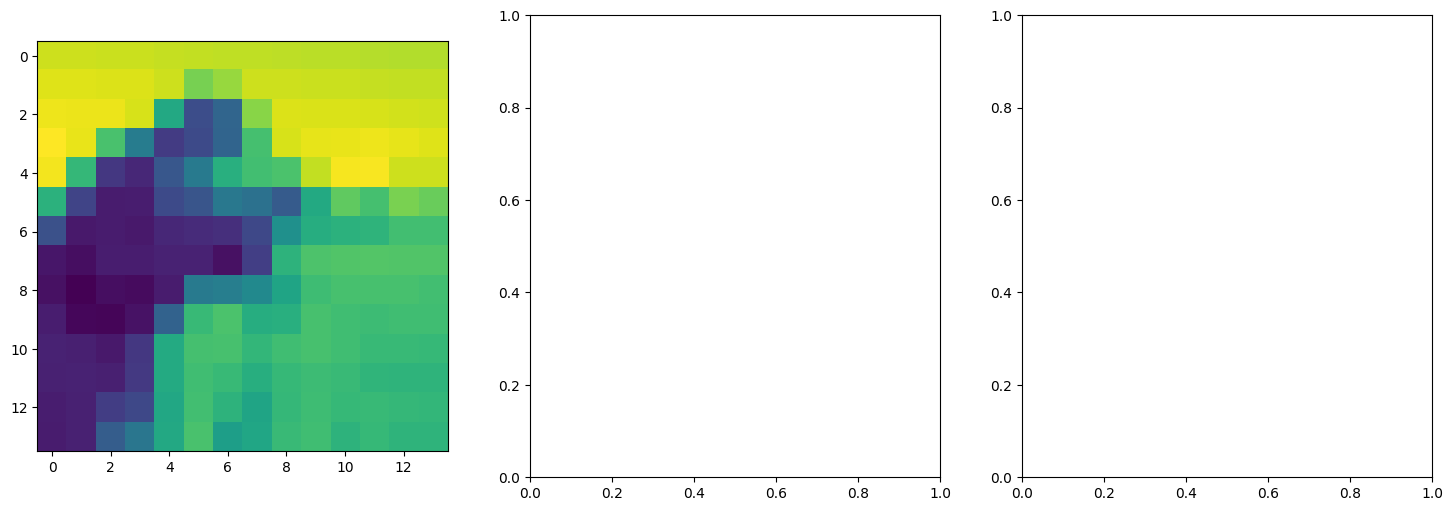

Step 0, Total loss 0.575826


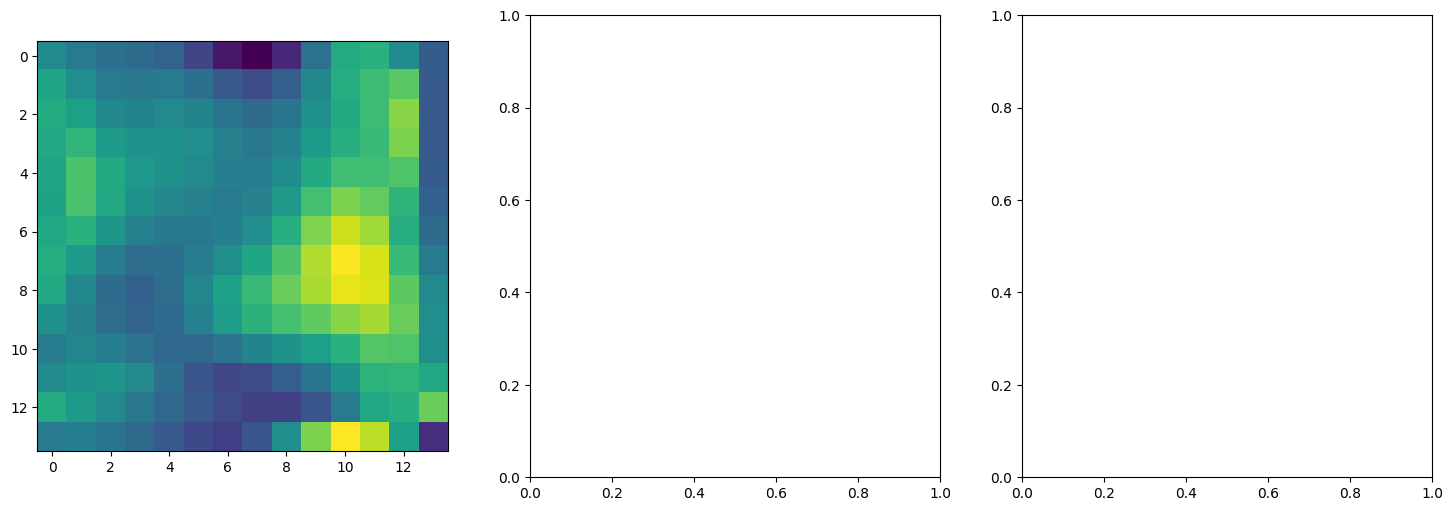

Step 5, Total loss 0.237459


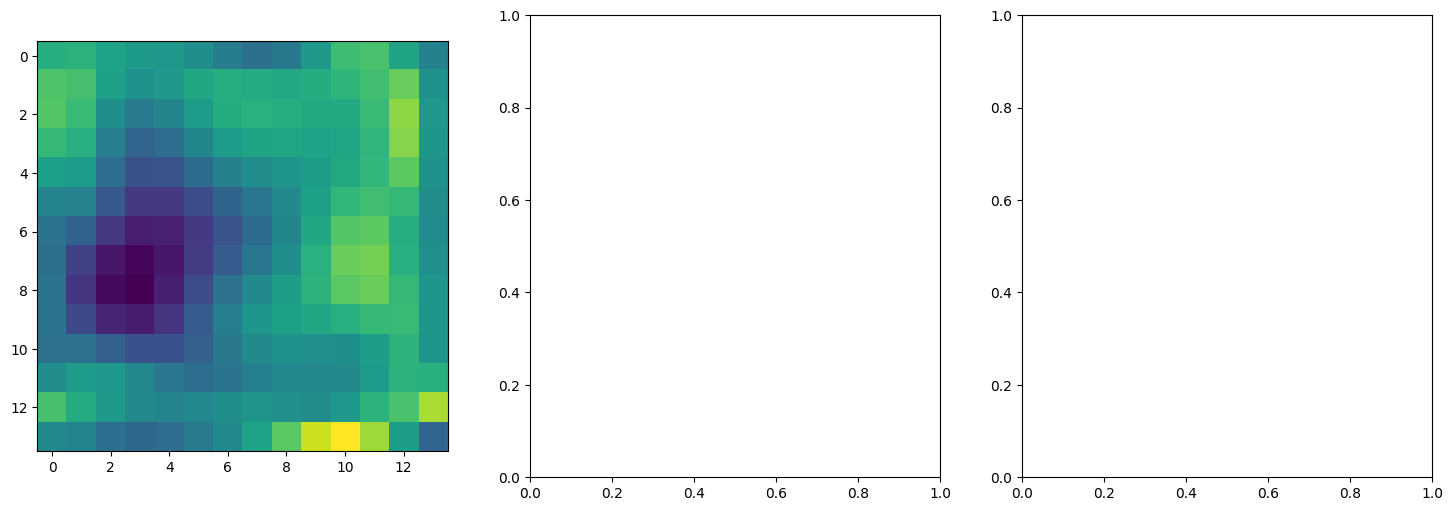

Step 10, Total loss 0.168445


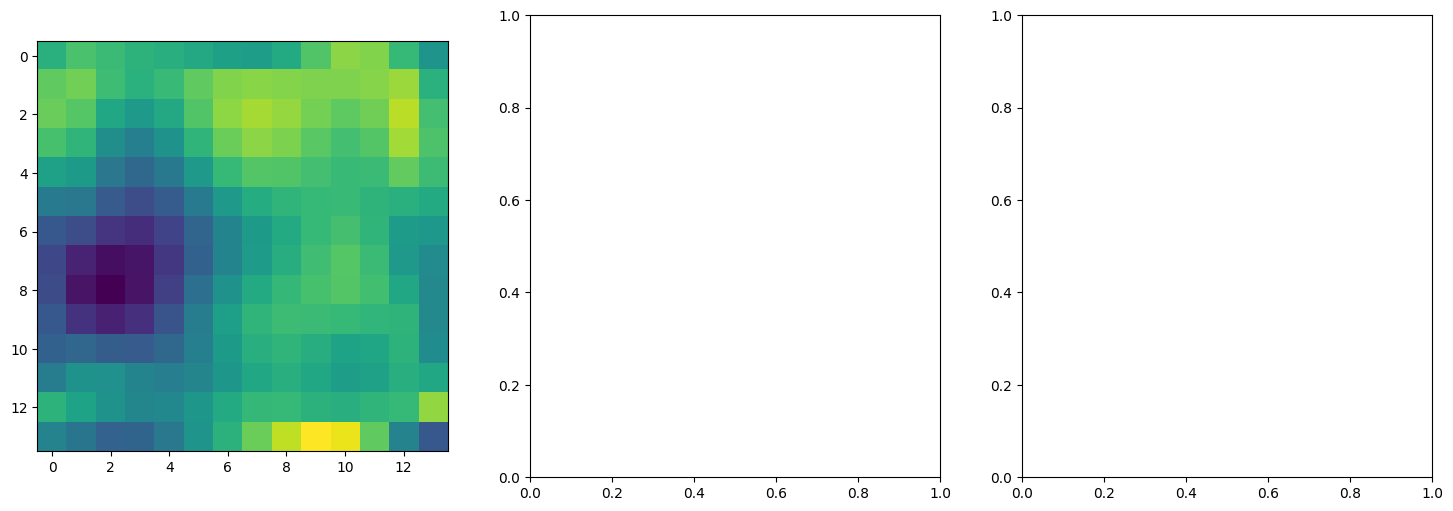

Step 15, Total loss 0.122504


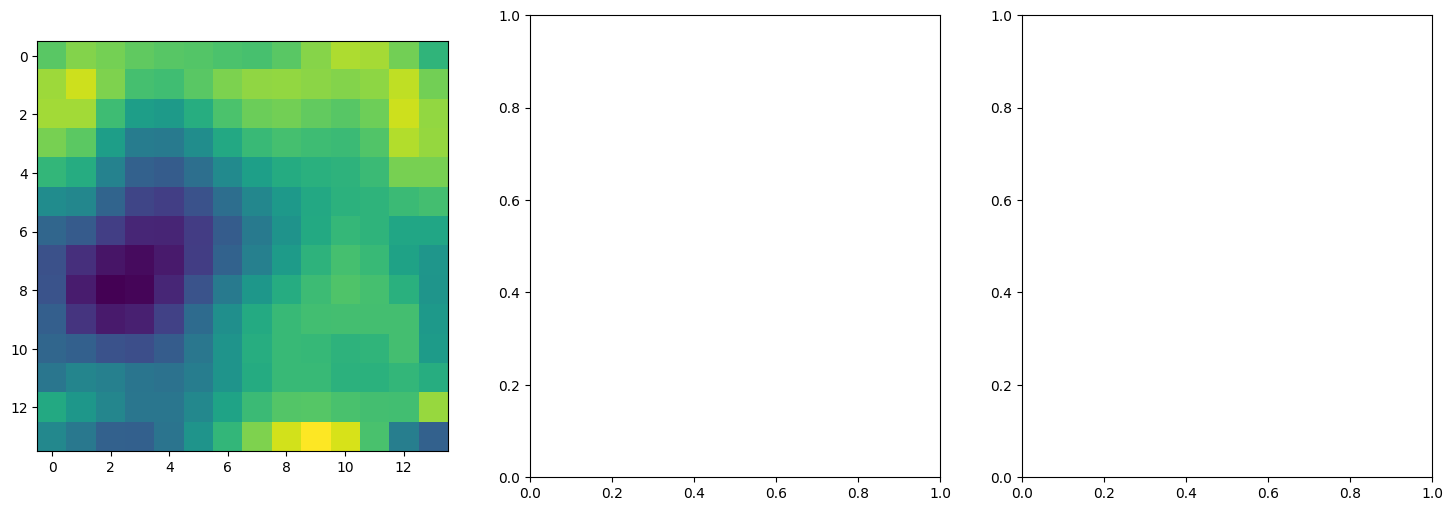

Step 20, Total loss 0.094224


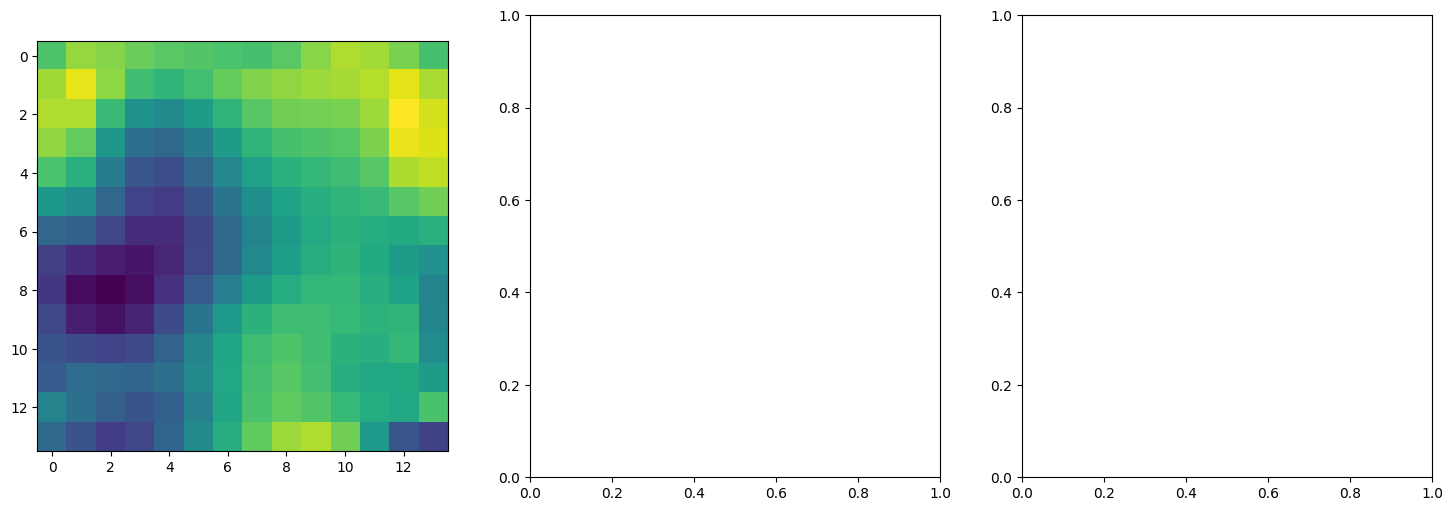

Step 25, Total loss 0.076838


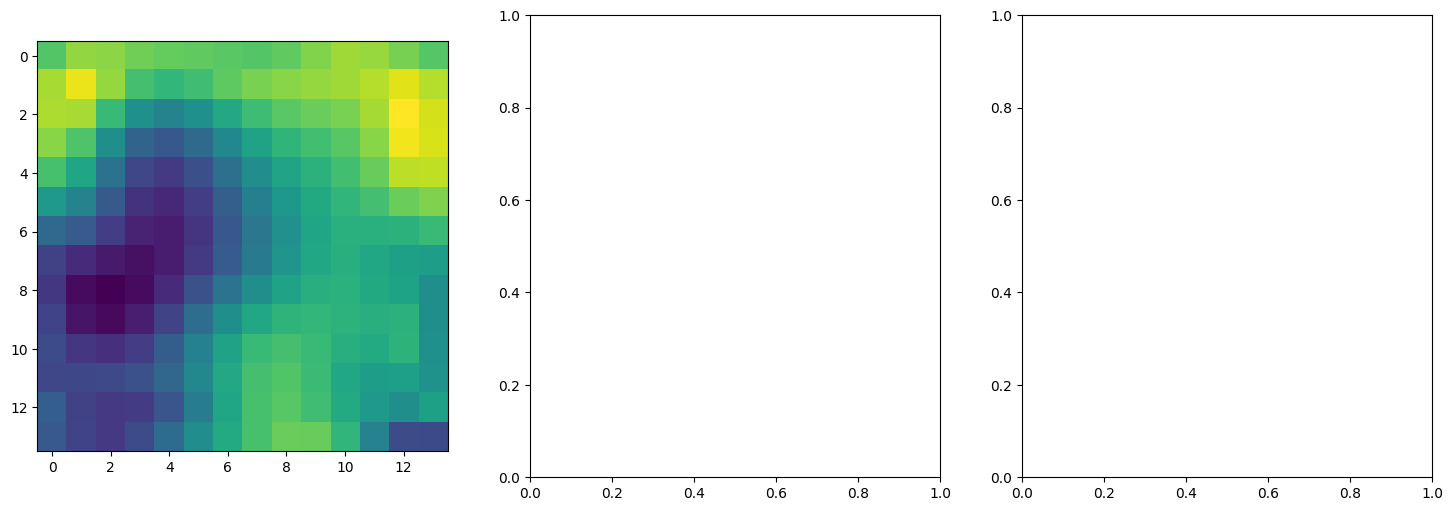

Step 30, Total loss 0.067321


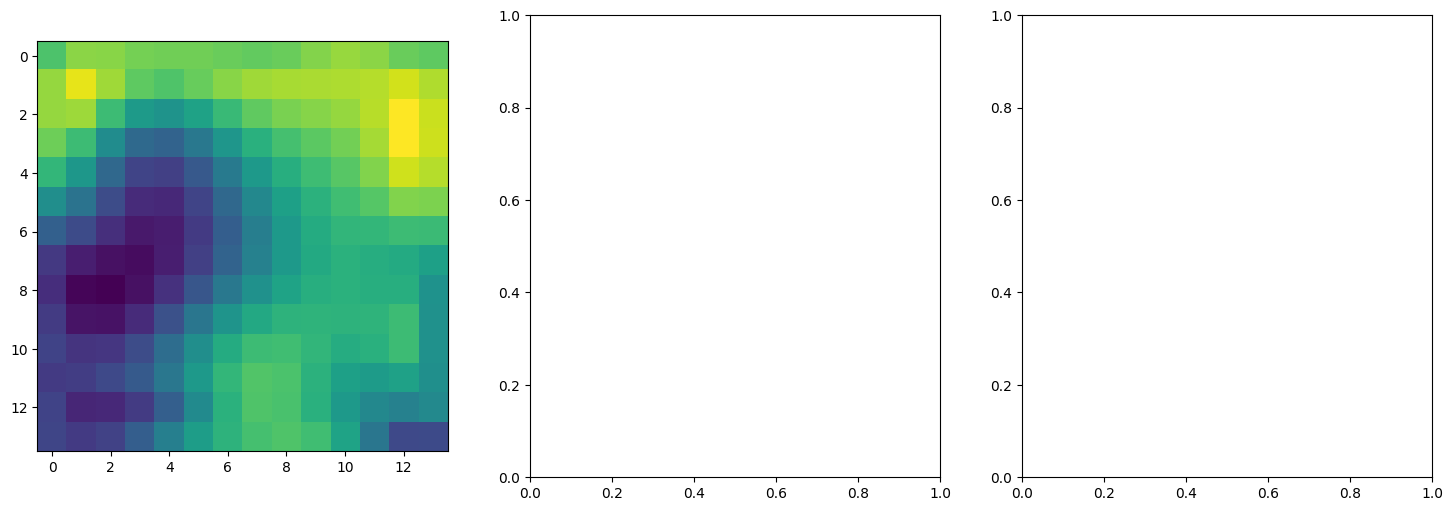

Step 35, Total loss 0.060163


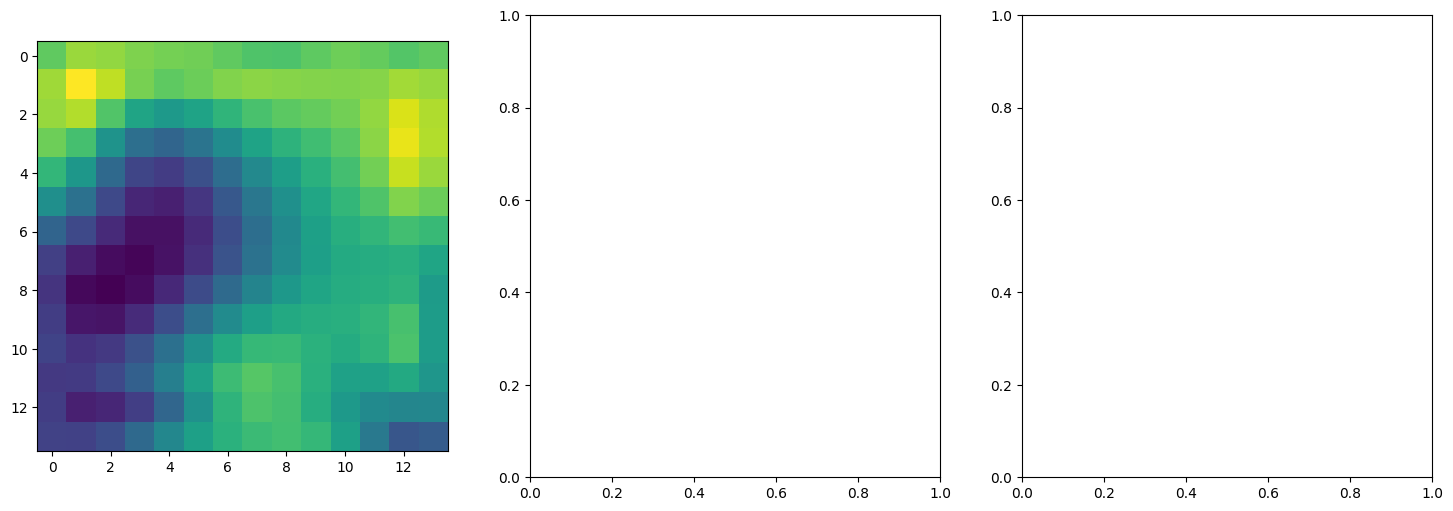

Step 40, Total loss 0.053802


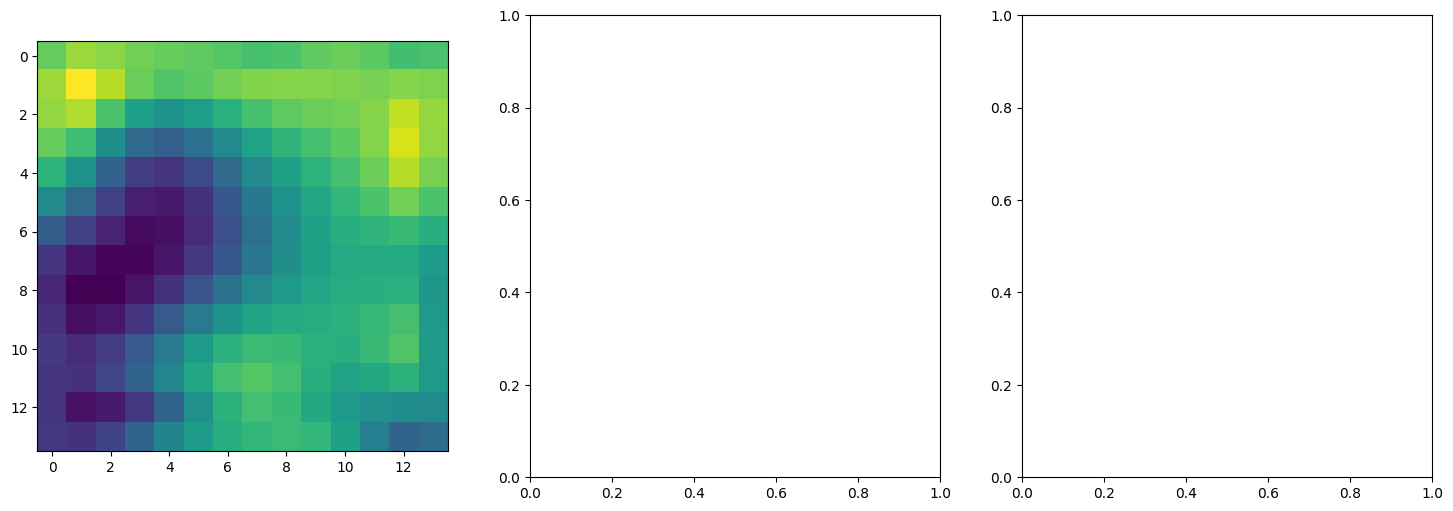

Step 45, Total loss 0.048842


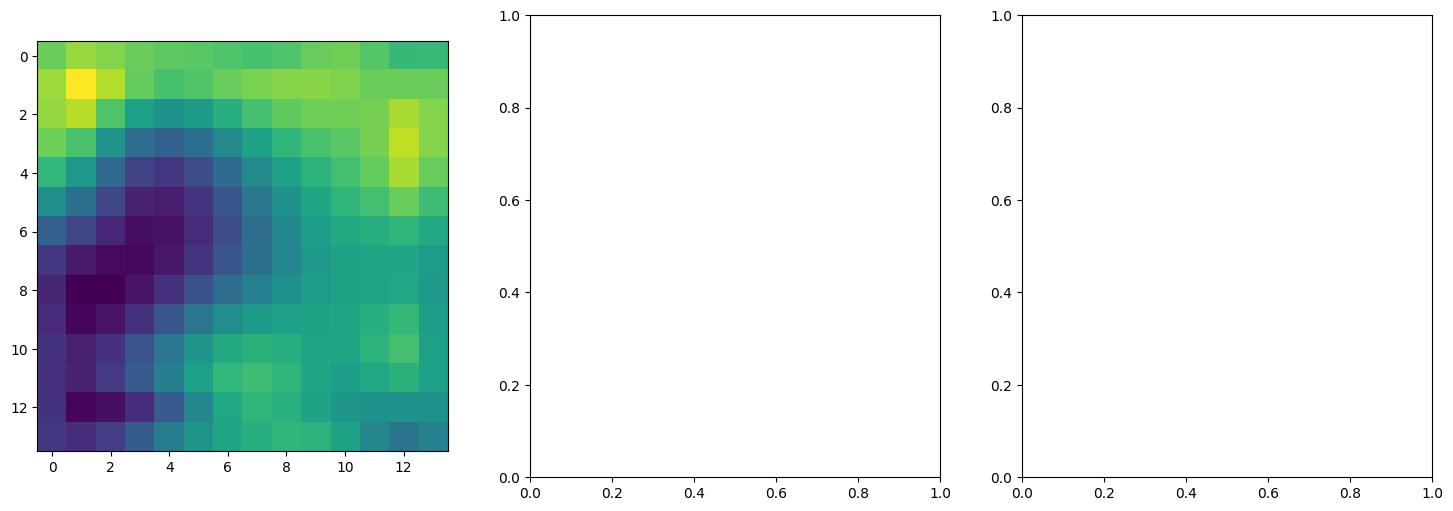

Step 50, Total loss 0.045710


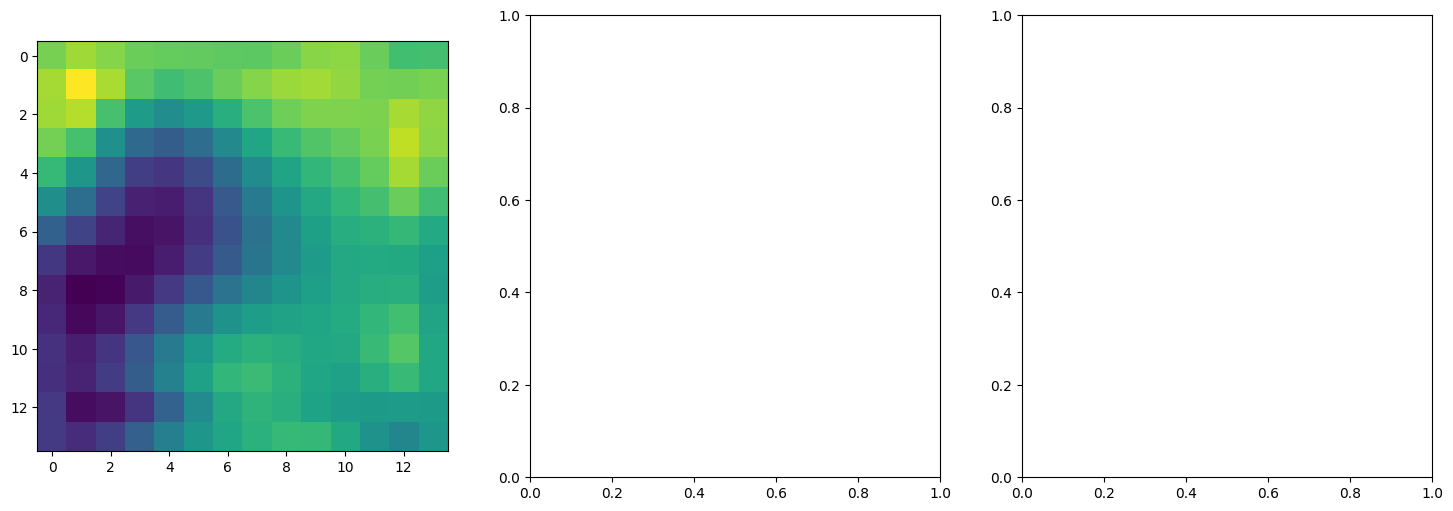

Step 55, Total loss 0.043464


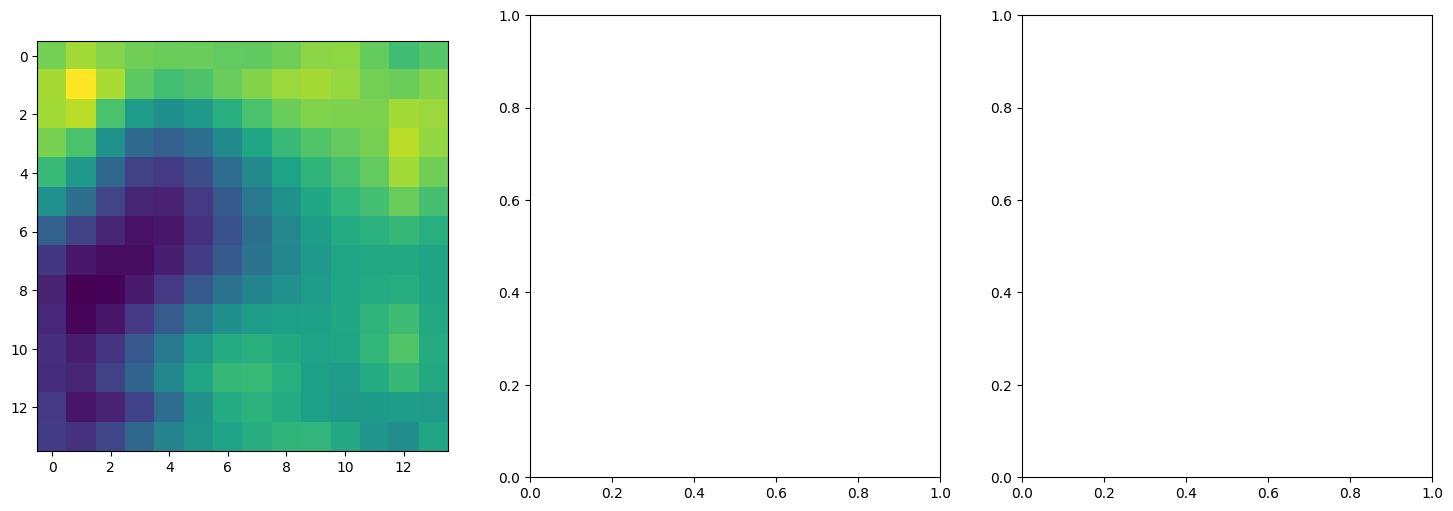

Step 60, Total loss 0.041719


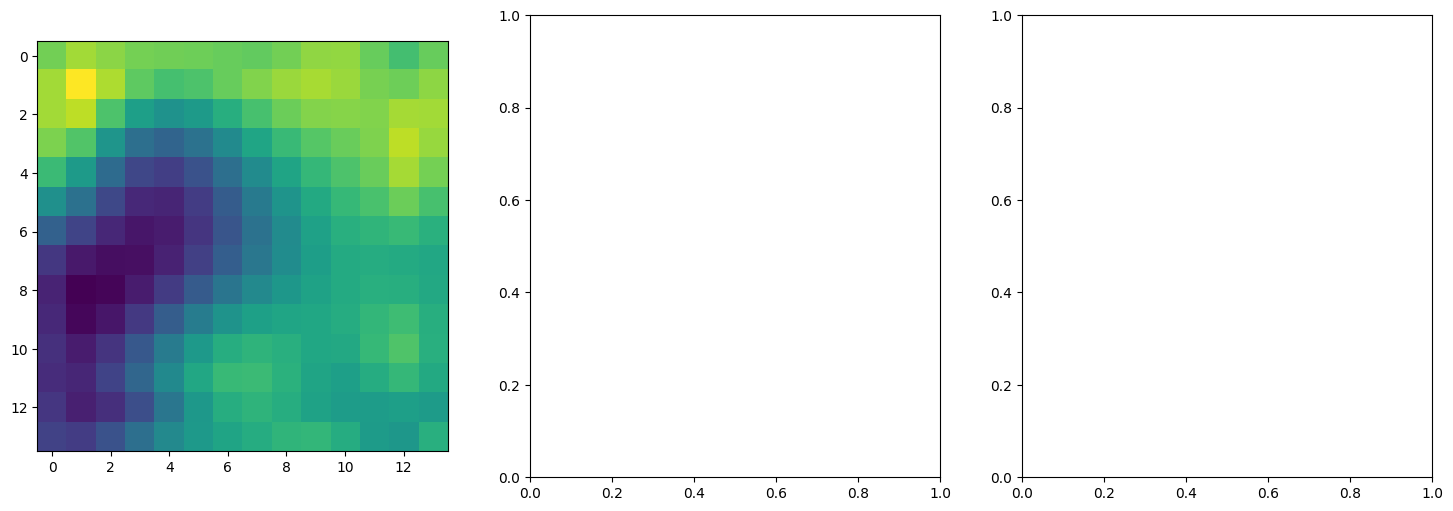

Step 65, Total loss 0.040551


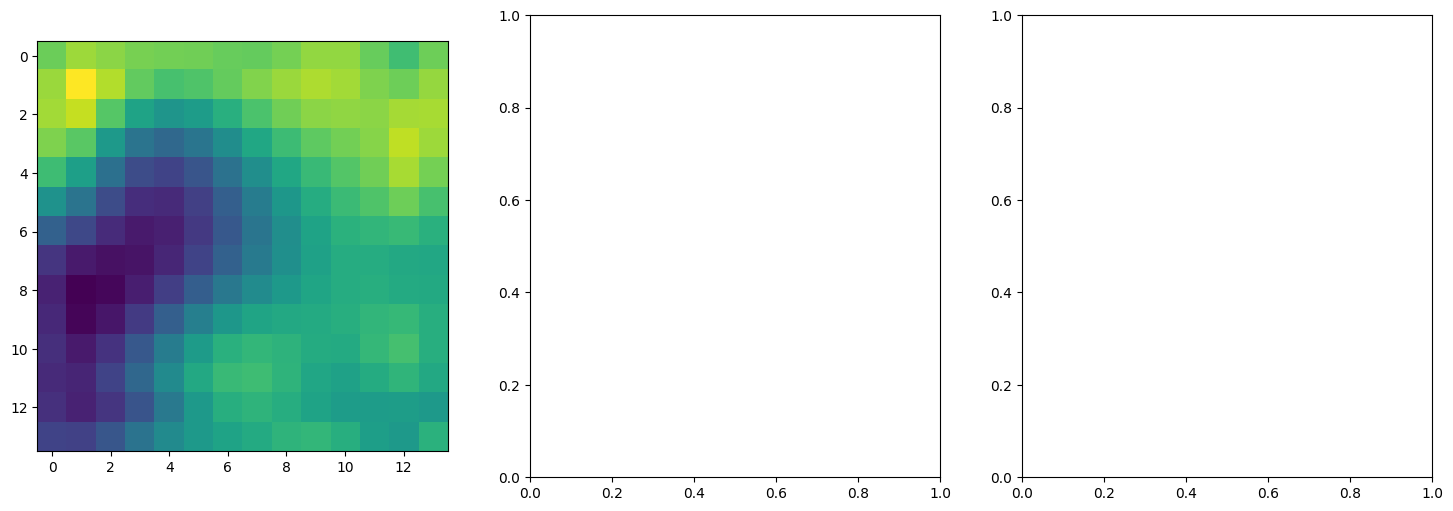

Step 70, Total loss 0.039676


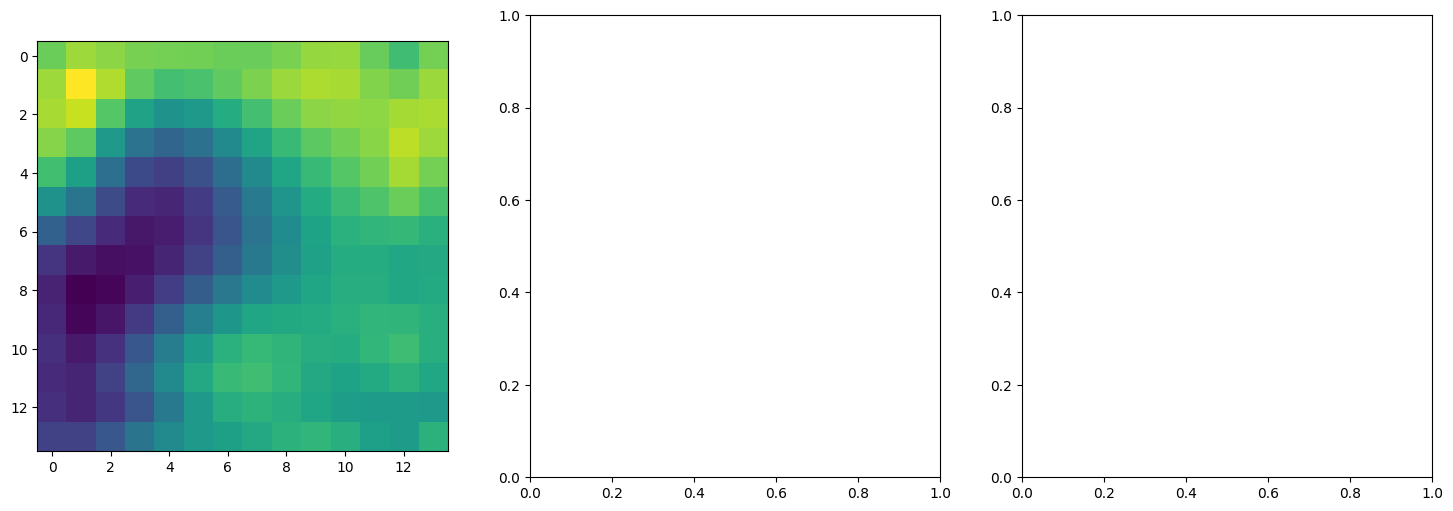

Step 75, Total loss 0.038973


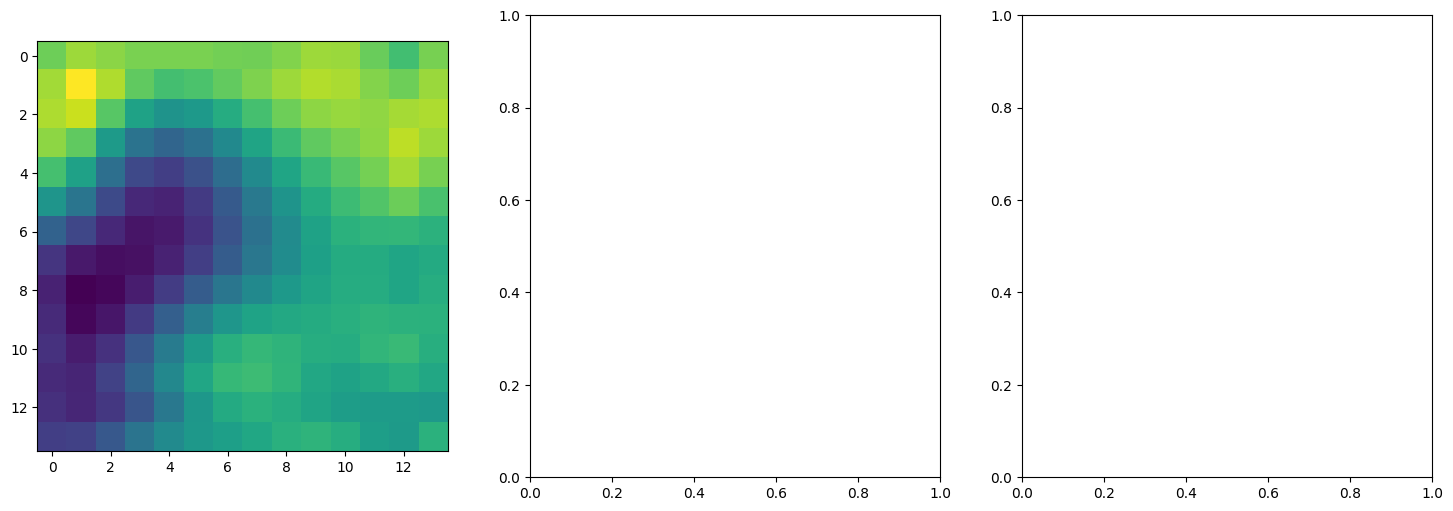

Step 80, Total loss 0.038352


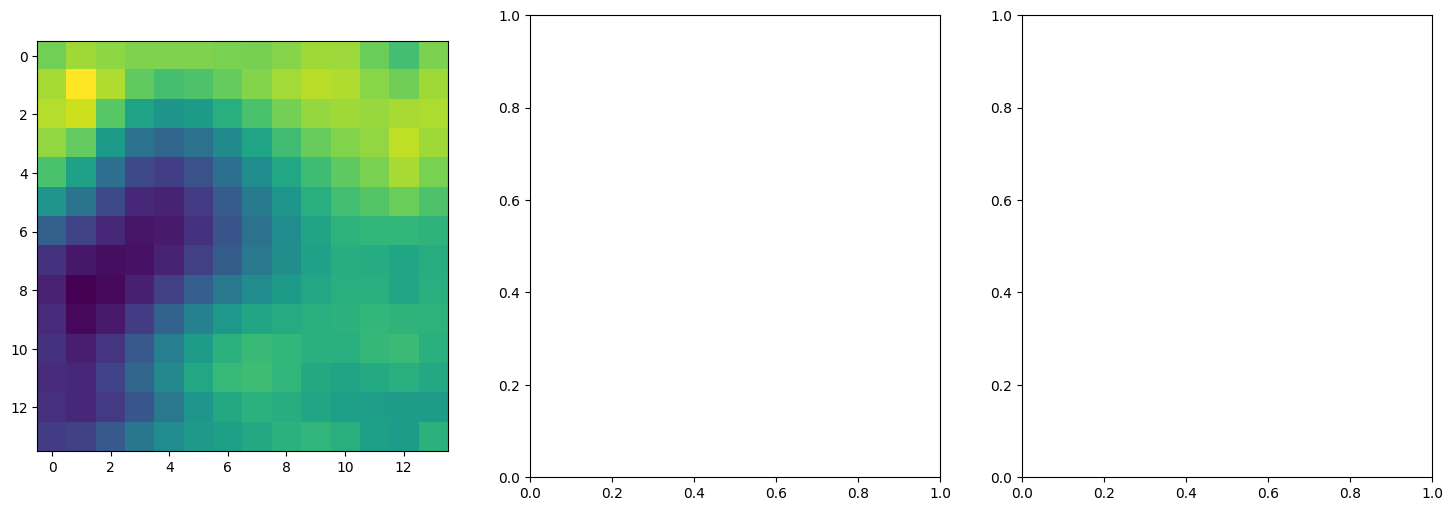

Step 85, Total loss 0.037816


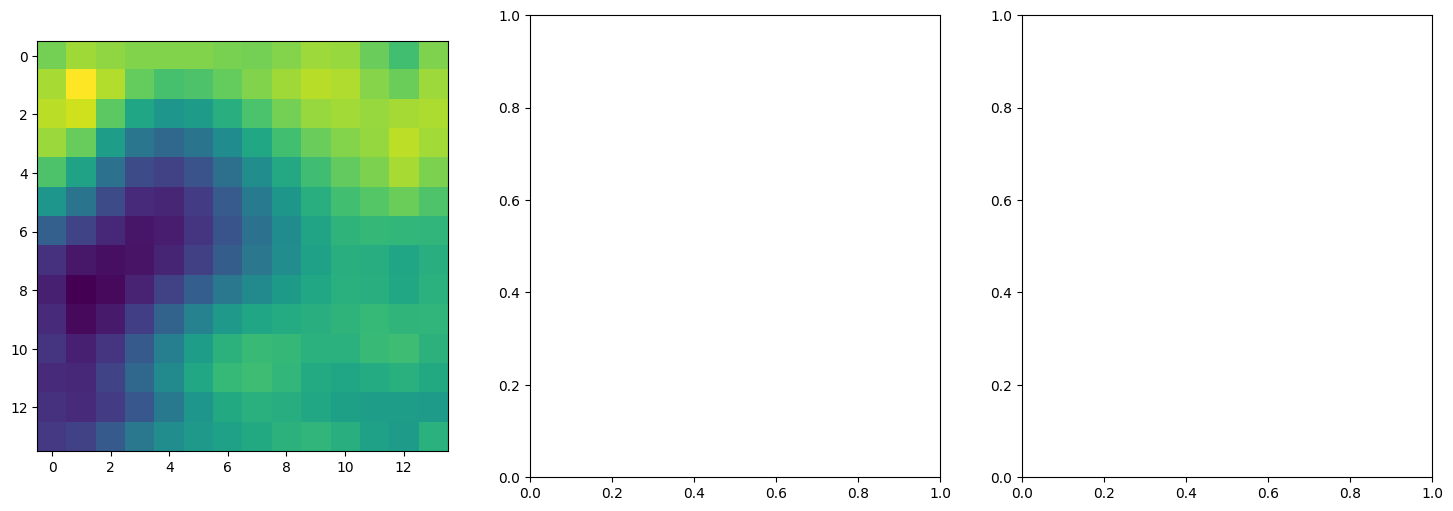

Step 90, Total loss 0.037343


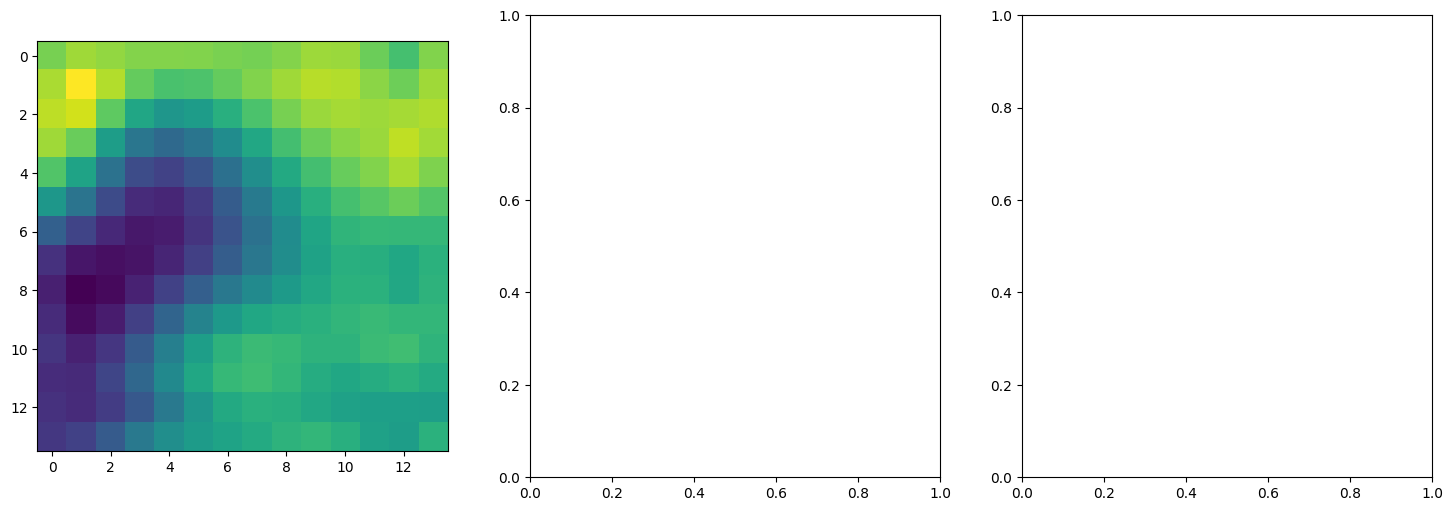

Step 95, Total loss 0.036905


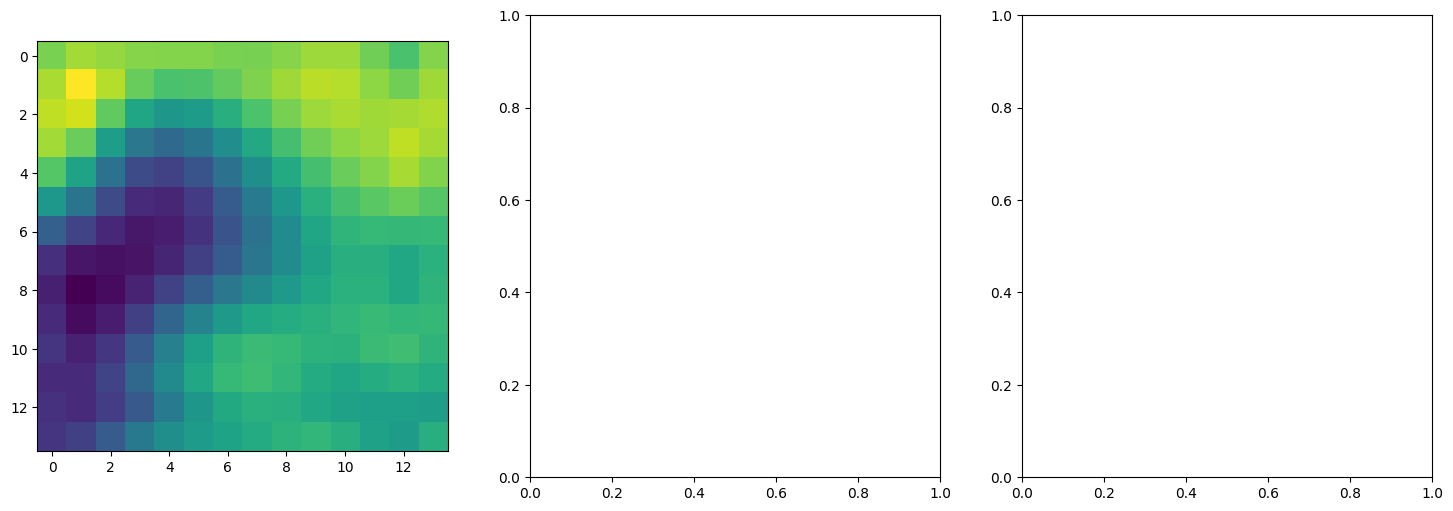

Step 100, Total loss 0.036499


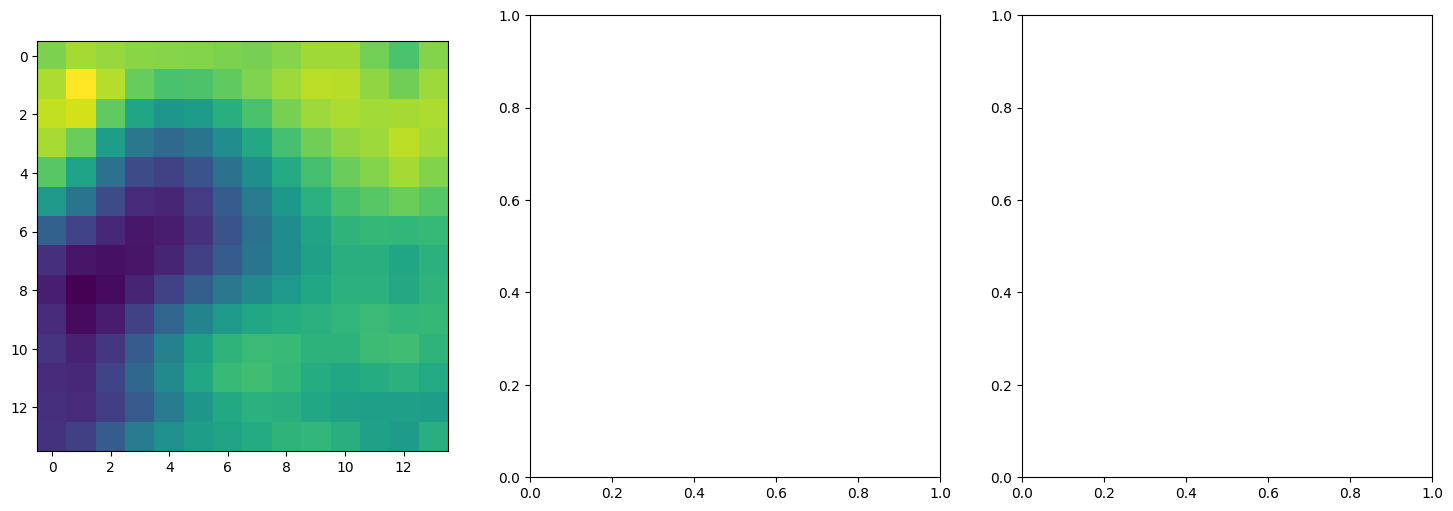

Step 105, Total loss 0.036119


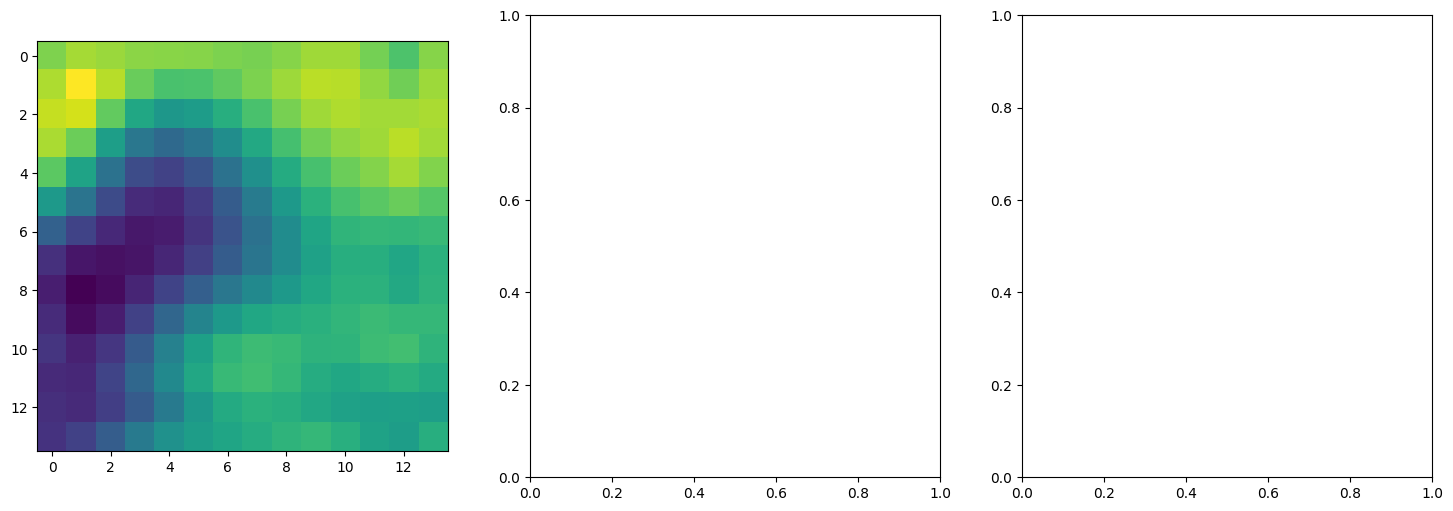

Step 110, Total loss 0.035760


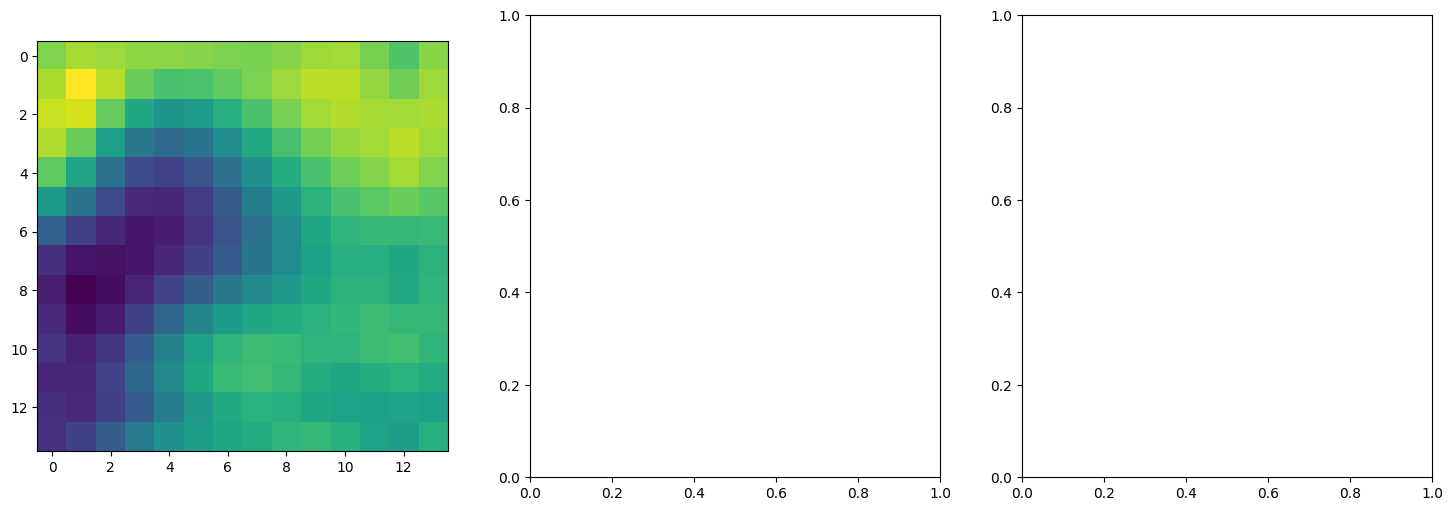

Step 115, Total loss 0.035418


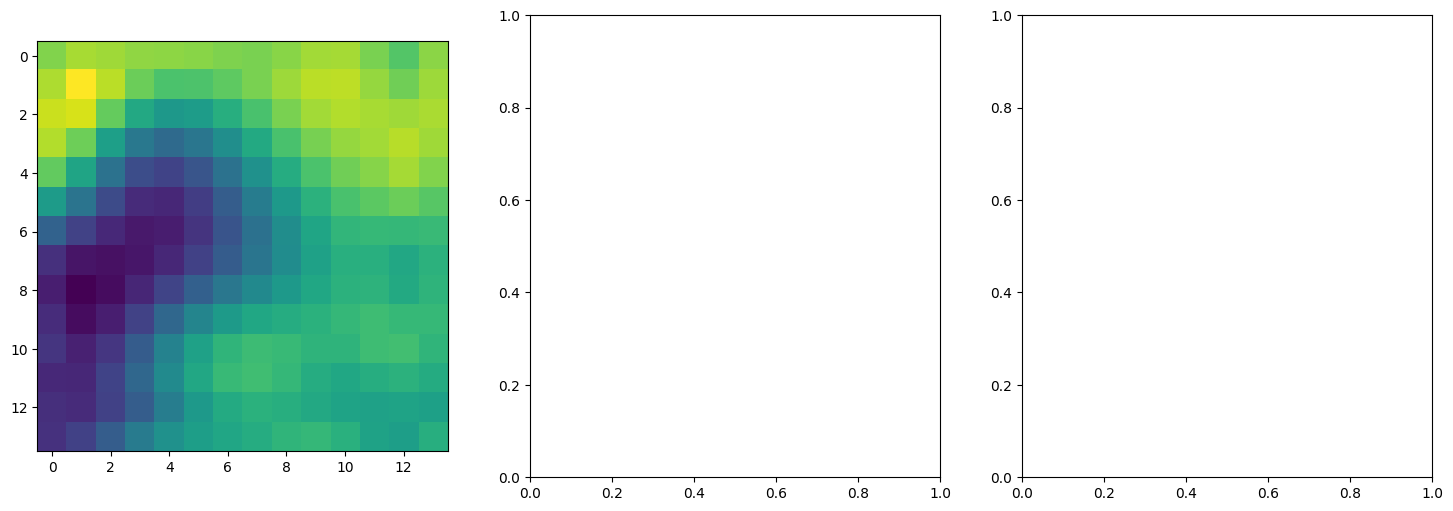

Step 120, Total loss 0.035089


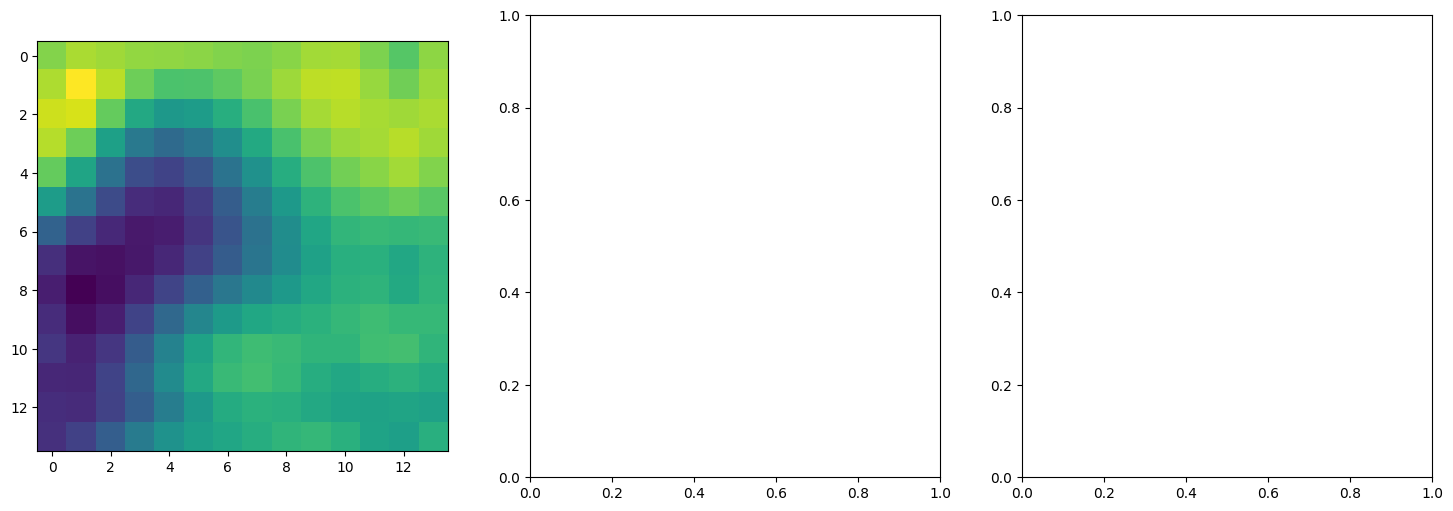

KeyboardInterrupt: 

In [9]:
# params = np.random.uniform(size=(sidelength,sidelength))
params = torch.rand(size=(n_layer,n_qubits,n_gates_per_layer), requires_grad=True) # nLayers, nQubits, nGatesPerLayer

optim = torch.optim.Adam(lr=1e-2, params=[params])

fig, axes = plt.subplots(1,3, figsize=(18,6))
axes[0].imshow(ground_truth.cpu().view(sidelength,sidelength).detach().numpy())
plt.show()

for step in range(total_steps):
    # model_output, coords = img_siren(model_input)

    model_output = cost(model_input[0], params)
    model_output = model_output.reshape((1, model_output.shape[0], 1))
    coords = model_input

    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        # print(f"Params: {params}")
        # img_grad = gradient(model_output, coords)
        # img_laplacian = laplace(model_output, coords)

        fig, axes = plt.subplots(1,3, figsize=(18,6))
        axes[0].imshow(model_output.cpu().view(sidelength,sidelength).detach().numpy())
        # axes[1].imshow(img_grad.norm(dim=-1).cpu().view(sidelength,sidelength).detach().numpy())
        # axes[2].imshow(img_laplacian.cpu().view(sidelength,sidelength).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()